# Experiment

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from IPython.display import display
import matplotlib.pyplot as plt

from models import get_global_threshold, get_individual_thresholds
from models import get_global_similarity_log_reg, get_similarity_log_reg
from models import get_embeddings_log_reg
from models import get_global_sim_X_y, get_concept_sim_X_y

from calibration_framework import apply_platt_scaling, apply_isotonic_regression, apply_temperature_scaling
from calibration_framework import apply_histogram_binning, apply_beta_calibration
from calibration_framework import apply_platt_scaling_v2, apply_temperature_scaling_v2

from utils import compare_all_models_calibration_metric, compare_all_models_calibration_avg, compare_all_models_calibration_concept

In [2]:
datasets = ['CLEVR', 'CUB', 'true-false-dataset']
dataset_name = datasets[2]

## 1. Get pre-processed data

In [3]:
metadata_df = pd.read_csv(f'../Data/{dataset_name}/metadata.csv')
embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')
cosine_similarity_df = pd.read_csv(f'Cosine_Similarities/{dataset_name}/train_cosine_similarities.csv')

if dataset_name == 'CLEVR':
    metadata_df = metadata_df.drop(['size::large','material::rubber'], axis=1)
    cosine_similarity_df = cosine_similarity_df.drop(['size::large','material::rubber'], axis=1)

concepts = list(cosine_similarity_df.columns)

train_mask = metadata_df['split'] == 'train'
train_embeddings = embeddings[train_mask]
train_metadata_df = metadata_df[train_mask].reset_index(drop=True)
train_cosine_similarity_df = cosine_similarity_df[train_mask].reset_index(drop=True)

cal_mask = metadata_df['split'] == 'calibration'
cal_embeddings = embeddings[cal_mask]
cal_metadata_df = metadata_df[cal_mask].reset_index(drop=True)
cal_cosine_similarity_df = cosine_similarity_df[cal_mask].reset_index(drop=True)

test_mask = metadata_df['split'] == 'test'
test_embeddings = embeddings[test_mask]
test_metadata_df = metadata_df[test_mask].reset_index(drop=True)
test_cosine_similarity_df = cosine_similarity_df[test_mask].reset_index(drop=True)

/tmp/ipykernel_500456/4219724837.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')


## 2. Train models

### (GT) Global Threshold

In [4]:
m1_models, m1_global_train_error, m1_train_errors = get_global_threshold(train_metadata_df, train_cosine_similarity_df,
                                                                        verbose=False)
m1_train_errors['Model'] = 'GT'

### (CT) Concept Threshold

In [5]:
m2_models, m2_train_errors = get_individual_thresholds(train_metadata_df, train_cosine_similarity_df, verbose=False)
m2_train_errors['Model'] = 'CT'

### (GLR) Global Similarity LogReg

In [6]:
m3_models, m3_global_train_error, m3_train_errors = get_global_similarity_log_reg(train_metadata_df, 
                                                                                  train_cosine_similarity_df,
                                                                                  verbose=False)
m3_train_errors['Model'] = 'GLR'

### (CLR) Concept Similarity LogReg

In [7]:
m4_models, m4_train_errors = get_similarity_log_reg(train_metadata_df, train_cosine_similarity_df, verbose=False)
m4_train_errors['Model'] = 'CLR'

### (EmbCLR) Embeddings Concept LogReg

In [8]:
m5_models, m5_train_errors = get_embeddings_log_reg(train_embeddings, train_metadata_df, train_cosine_similarity_df,
                                                   verbose=False)
m5_train_errors['Model'] = 'EmbCLR'

In [9]:
base_models = {'GT': m1_models,
               'CT': m2_models,
               'GLR': m3_models,
               'CLR': m4_models,
               'EmbCLR': m5_models
         }

### 2.1 Evaluate training classification error

In [10]:
error_comparison_df = pd.DataFrame.from_dict([m1_train_errors, 
                                              m2_train_errors,
                                              m3_train_errors,
                                              m4_train_errors,
                                              m5_train_errors
                                             ])
error_comparison_df = error_comparison_df.set_index('Model')
if dataset_name == 'CUB':
    error_comparison_df = error_comparison_df.transpose()
    display(error_comparison_df.describe())
else:
    display(error_comparison_df)

,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
GT,0.489898,0.017318,0.087641,0.070060,0.008922,0.118342,0.155077,0.070585
CT,0.498819,0.017318,0.079507,0.016531,0.006822,0.092102,0.042771,0.063500
GLR,0.499082,0.023353,0.124114,0.126214,0.015219,0.092627,0.125689,0.101548
CLR,0.520073,0.019155,0.082131,0.025453,0.009709,0.096300,0.042771,0.134086
EmbCLR,0.001050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 3. Calibrate models

In [11]:
X_cal, y_cal, _, _ = get_global_sim_X_y(cal_metadata_df, cal_cosine_similarity_df)

m3_models_cal = {}

m3_models_cal['Platt'] = apply_platt_scaling(m3_models, X_cal, y_cal)
m3_models_cal['Isotonic'] = apply_isotonic_regression(m3_models, X_cal, y_cal)

#m3_models_cal['Temperature'] = apply_temperature_scaling(m3_models, X_cal, y_cal, verbose=False)
#m3_models_cal['Platt v2'] = apply_platt_scaling_v2(m3_models, X_cal, y_cal)

m3_models_cal['Temperature'] = apply_temperature_scaling_v2(m3_models, X_cal, y_cal)

In [12]:
m3_models_cal['Histogram'] = apply_histogram_binning(m3_models, X_cal, y_cal, nbins=10)
m3_models_cal['Beta'] = apply_beta_calibration(m3_models, X_cal, y_cal)

In [13]:
m4_models_cal = {}
m4_models_cal['Platt'] = {}
m4_models_cal['Isotonic'] = {}
m4_models_cal['Temperature'] = {}

#m4_models_cal['Platt v2'] = {}
#m4_models_cal['Temperature v2'] = {}

m4_models_cal['Histogram'] = {}
m4_models_cal['Beta'] = {}

for concept in m4_models.keys():
    X_cal, y_cal = get_concept_sim_X_y(cal_metadata_df, cal_cosine_similarity_df, concept)

    m4_models_cal['Platt'][concept] = apply_platt_scaling(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Isotonic'][concept] = apply_isotonic_regression(m4_models[concept], X_cal, y_cal)
    #m4_models_cal['Temperature'][concept] = apply_temperature_scaling(m4_models[concept], X_cal, y_cal, verbose=False)
    
    #m4_models_cal['Platt v2'][concept] = apply_platt_scaling_v2(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Temperature'][concept] = apply_temperature_scaling_v2(m4_models[concept], X_cal, y_cal)
    
    m4_models_cal['Histogram'][concept] = apply_histogram_binning(m4_models[concept], X_cal, y_cal, nbins=10)
    m4_models_cal['Beta'][concept] = apply_beta_calibration(m4_models[concept], X_cal, y_cal)

In [14]:
m5_models_cal = {}
m5_models_cal['Platt'] = {}
m5_models_cal['Isotonic'] = {}
m5_models_cal['Temperature'] = {}

#m5_models_cal['Platt v2'] = {}
#m5_models_cal['Temperature v2'] = {}

m5_models_cal['Histogram'] = {}
m5_models_cal['Beta'] = {}

for concept in m5_models.keys():
    X_cal = cal_embeddings
    y_cal = (cal_metadata_df[concept]==1).to_numpy().astype(int)

    m5_models_cal['Platt'][concept] = apply_platt_scaling(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Isotonic'][concept] = apply_isotonic_regression(m5_models[concept], X_cal, y_cal)
    #m5_models_cal['Temperature'][concept] = apply_temperature_scaling(m5_models[concept], X_cal, y_cal, verbose=False)
    
    #m5_models_cal['Platt v2'][concept] = apply_platt_scaling_v2(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Temperature'][concept] = apply_temperature_scaling_v2(m5_models[concept], X_cal, y_cal)
    
    m5_models_cal['Histogram'][concept] = apply_histogram_binning(m5_models[concept], X_cal, y_cal, nbins=10)
    m5_models_cal['Beta'][concept] = apply_beta_calibration(m5_models[concept], X_cal, y_cal)

In [15]:
calibrated_models = {'GLR': m3_models_cal,
                     'CLR': m4_models_cal,
                     'EmbCLR': m5_models_cal
                    }

## 4. Evaluate models

In [16]:
results_path = f"Results/{dataset_name}/"
os.makedirs(results_path, exist_ok=True)

### 4.1 Get a single metric for all models, calibration methods, and concepts

**Use only if you don't have many concepts!**

In [17]:
metric = 'Acc'

if len(concepts) <= 10:
    metric_df = compare_all_models_calibration_metric(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                       test_metadata_df, test_cosine_similarity_df, test_embeddings, 
                                       metric=metric)
    if not 'K' in metric:
        display(metric_df.style.highlight_max(color='grey'))
    else:
        display(metric_df)

In [18]:
#metric_df = metric_df.replace('-', np.nan)
#for col in metric_df.columns:
#    metric_df[col] = metric_df[col].apply(lambda x: '{0:.3f}'.format(x))
#metric_df = metric_df.replace('nan', '-')
#
#with open(os.path.join(results_path, f'metric_{metric}_concepts.tex'), 'w') as tf:
#     tf.write(metric_df.to_latex())


### 4.2 Get the average of all metrics over the concepts for all models and calibration methods

In [19]:
metrics_avg_df = compare_all_models_calibration_avg(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                   test_metadata_df, test_cosine_similarity_df, test_embeddings)
metrics_avg_df.to_csv(os.path.join(results_path, 'metrics_average.csv'))
with open(os.path.join(results_path, 'metrics_average.tex'), 'w') as tf:
     tf.write(metrics_avg_df.to_latex())

with open(os.path.join(results_path, 'metrics_average_short.tex'), 'w') as tf:
     tf.write(metrics_avg_df[['Acc','K1','Kmax']].to_latex())
    
metrics_avg_df#.style.highlight_max(color='grey', subset=['Acc','F1','AUC'])

Acc             F1            AUC  \
Model  Calibration                                                
GT     None         0.869 ± 0.149  0.603 ± 0.318              -   
CT     None         0.897 ± 0.164  0.637 ± 0.381              -   
GLR    None         0.859 ± 0.150  0.468 ± 0.344  0.812 ± 0.174   
       Histogram    0.869 ± 0.150  0.604 ± 0.316  0.813 ± 0.173   
       Isotonic     0.869 ± 0.148  0.589 ± 0.320  0.823 ± 0.170   
       Platt        0.861 ± 0.150  0.494 ± 0.334  0.812 ± 0.174   
       Temperature  0.859 ± 0.150  0.468 ± 0.344  0.812 ± 0.174   
       Beta         0.866 ± 0.149  0.558 ± 0.324  0.812 ± 0.174   
CLR    None         0.885 ± 0.168  0.513 ± 0.442  0.807 ± 0.183   
       Histogram    0.899 ± 0.159  0.640 ± 0.356  0.803 ± 0.212   
       Isotonic     0.897 ± 0.167  0.655 ± 0.354  0.825 ± 0.173   
       Platt        0.894 ± 0.165  0.604 ± 0.407  0.812 ± 0.174   
       Temperature  0.887 ± 0.163  0.458 ± 0.479  0.810 ± 0.178   
       Beta         0.897 ± 0.164  0.635 ± 0.388  0.810 ± 0.178   
EmbCLR None         0.981 ± 0.049  0.970 ± 0.050  0.992 ± 0.023   
       Histogram    0.981 ± 0.050  0.972 ± 0.049  0.982 ± 0.038   
       Isotonic     0.981 ± 0.049  0.972 ± 0.049  0.992 ± 0.023   
       Platt        0.982 ± 0.048  0.971 ± 0.050  0.992 ± 0.023   
       Temperature  0.981 ± 0.049  0.970 ± 0.050  0.992 ± 0.023   
       Beta         0.981 ± 0.049  0.973 ± 0.048  0.992 ± 0.023   

                               K1             K2           Kmax  
Model  Calibration                                               
GT     None                     -              -              -  
CT     None                     -              -              -  
GLR    None         0.150 ± 0.040  0.041 ± 0.020  0.049 ± 0.019  
       Histogram    0.121 ± 0.067  0.034 ± 0.032  0.052 ± 0.036  
       Isotonic     0.117 ± 0.065  0.034 ± 0.031  0.054 ± 0.042  
       Platt        0.153 ± 0.036  0.042 ± 0.019  0.050 ± 0.017  
       Temperature  0.153 ± 0.037  0.042 ± 0.018  0.050 ± 0.016  
       Beta         0.124 ± 0.069  0.035 ± 0.035  0.046 ± 0.028  
CLR    None         0.071 ± 0.057  0.014 ± 0.015  0.022 ± 0.013  
       Histogram    0.009 ± 0.004  0.000 ± 0.000  0.006 ± 0.003  
       Isotonic     0.014 ± 0.010  0.001 ± 0.001  0.007 ± 0.008  
       Platt        0.045 ± 0.060  0.008 ± 0.014  0.016 ± 0.015  
       Temperature  0.045 ± 0.062  0.010 ± 0.015  0.013 ± 0.016  
       Beta         0.027 ± 0.034  0.003 ± 0.005  0.010 ± 0.012  
EmbCLR None         0.015 ± 0.039  0.002 ± 0.005  0.007 ± 0.018  
       Histogram    0.005 ± 0.012  0.001 ± 0.002  0.002 ± 0.004  
       Isotonic     0.005 ± 0.012  0.001 ± 0.001  0.002 ± 0.004  
       Platt        0.007 ± 0.009  0.001 ± 0.001  0.003 ± 0.003  
       Temperature  0.005 ± 0.010  0.001 ± 0.001  0.002 ± 0.003  
       Beta         0.005 ± 0.011  0.001 ± 0.001  0.002 ± 0.003

### 4.3 Get all metrics for all models and calibration methods for a single concept

In [20]:
concept = concepts[0]

metrics_concept_df = compare_all_models_calibration_concept(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                   test_metadata_df, test_cosine_similarity_df, test_embeddings,
                                   concept=concept)
metrics_concept_df.to_csv(os.path.join(results_path, f'metrics_concept_{concept}.csv'))
with open(os.path.join(results_path, f'metrics_concept_{concept}.tex'), 'w') as tf:
     tf.write(metrics_concept_df.to_latex())

In [21]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values[s.values != '-']), props, '')
tmp = metrics_concept_df.style.apply(highlight_min, props='background-color:grey;', subset=['K1', 'K2', 'Kmax'])
tmp.highlight_max(color='grey', subset=['Acc','F1','AUC'])

In [22]:
if len(concepts) < 10:
    for concept in concepts:
        metrics_concept_df = compare_all_models_calibration_concept(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                           test_metadata_df, test_cosine_similarity_df, test_embeddings,
                                           concept=concept)
        metrics_concept_df.to_csv(os.path.join(results_path, f'metrics_concept_{concept}.csv'))
        with open(os.path.join(results_path, f'metrics_concept_{concept}.tex'), 'w') as tf:
             tf.write(metrics_concept_df.to_latex())

### 4.4 Plot metrics by concept

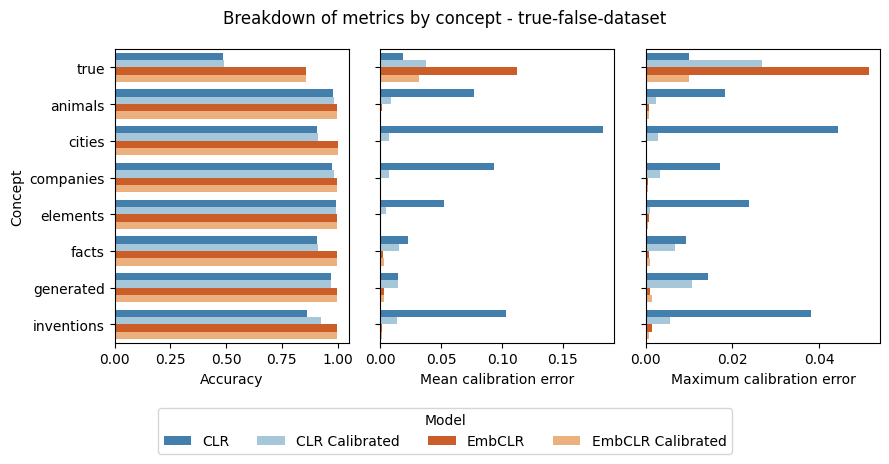

In [23]:
if len(concepts) < 10:
    from utils import plot_metrics_by_concept
    
    select_models = ['CLR', 'EmbCLR']
    select_calibration = ['Isotonic', 'Beta']
    
    models_dict = {select_models[0]: base_models[select_models[0]],
                   select_models[0]+' Calibrated': calibrated_models[select_models[0]][select_calibration[0]],
                   select_models[1]: base_models[select_models[1]],
                   select_models[1]+' Calibrated': calibrated_models[select_models[1]][select_calibration[1]],
                  }
    
    fig = plot_metrics_by_concept(models_dict, test_metadata_df, test_cosine_similarity_df, test_embeddings,
                           results_path, dataset_name)

## 5. Calibration curves

### a) Calibration error

In [24]:
from calibration import plot_calibration_curves_concept, plot_calibration_curves_avg, plot_calibrators

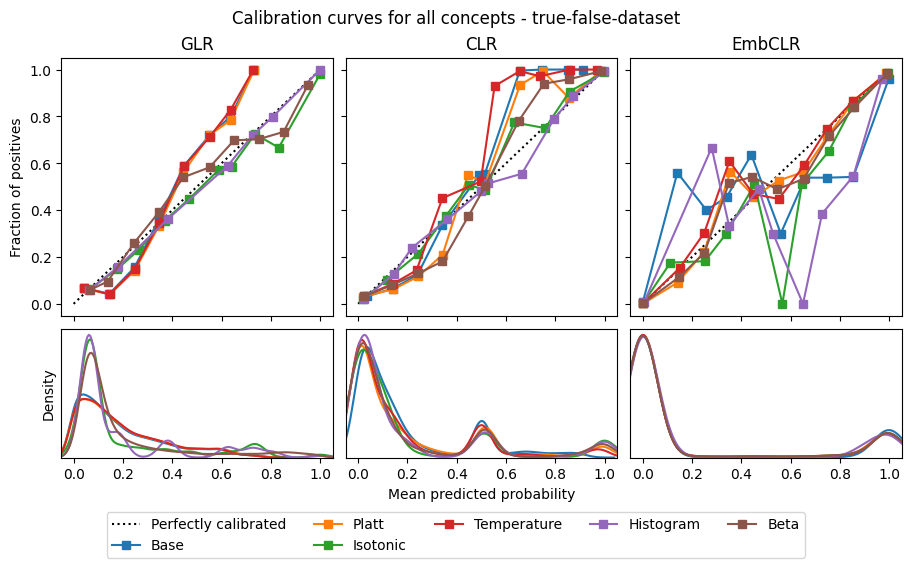

In [25]:
fig = plot_calibration_curves_avg(test_metadata_df, test_cosine_similarity_df, 
                                  test_embeddings, base_models, calibrated_models,
                                  results_path, dataset_name)

/tmp/ipykernel_500456/3625325580.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_500456/3625325580.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_500456/3625325580.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_500456/3625325580.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_500456/3625325580.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_500456/3625325580.py

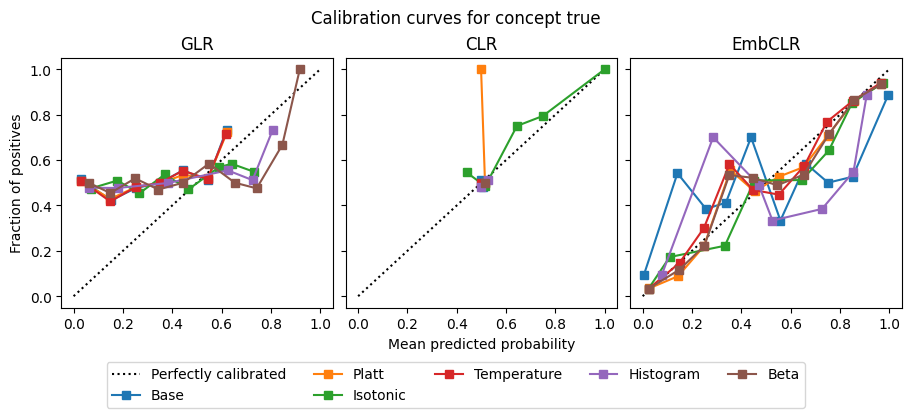

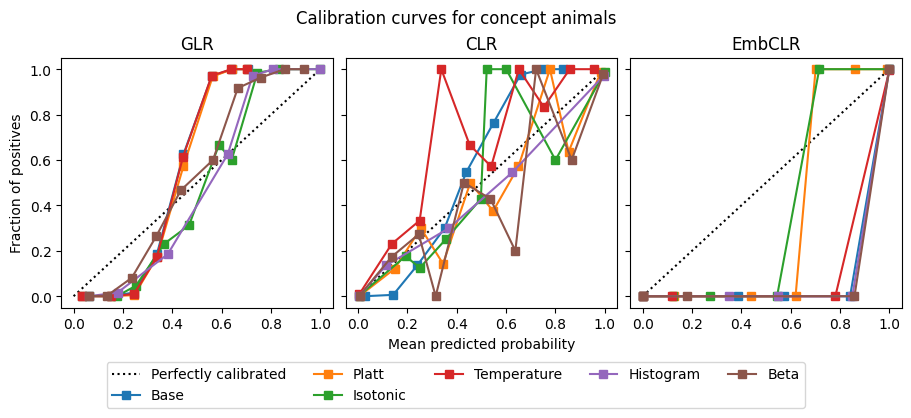

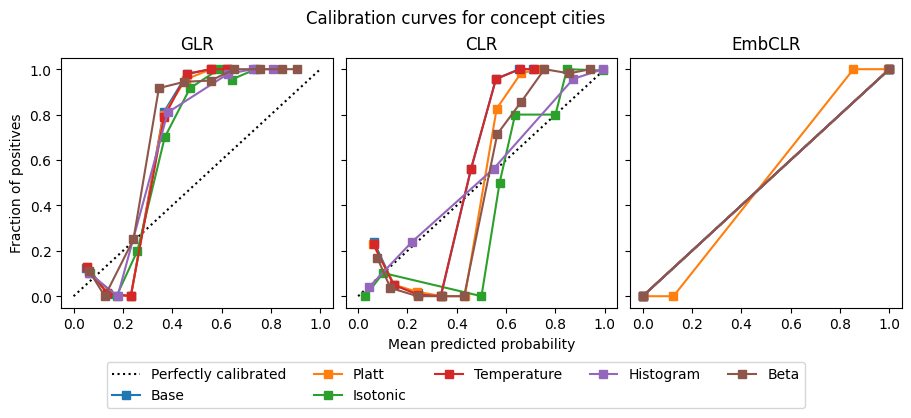

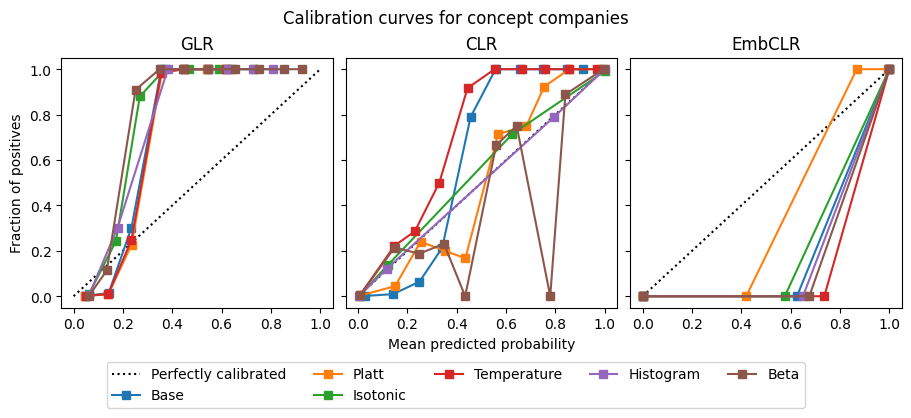

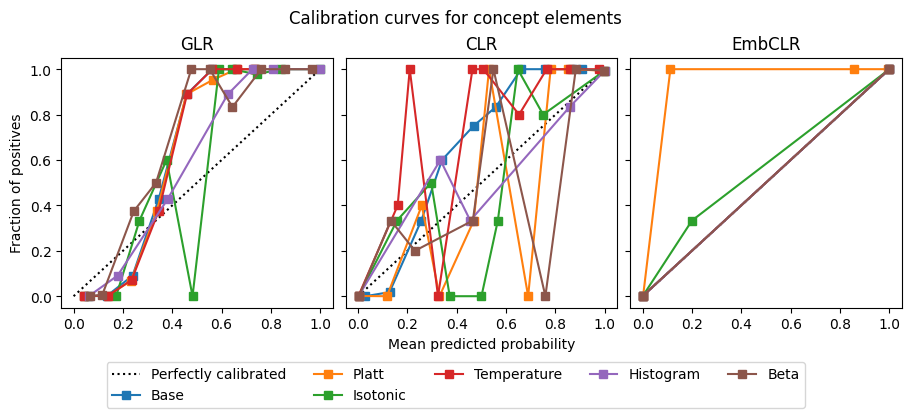

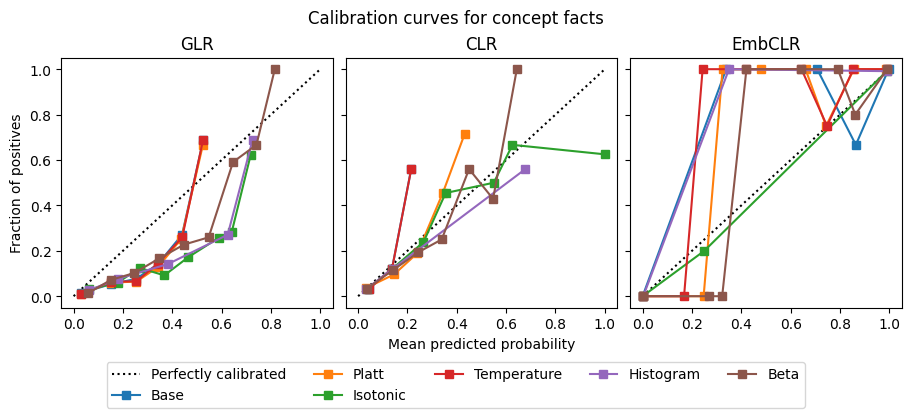

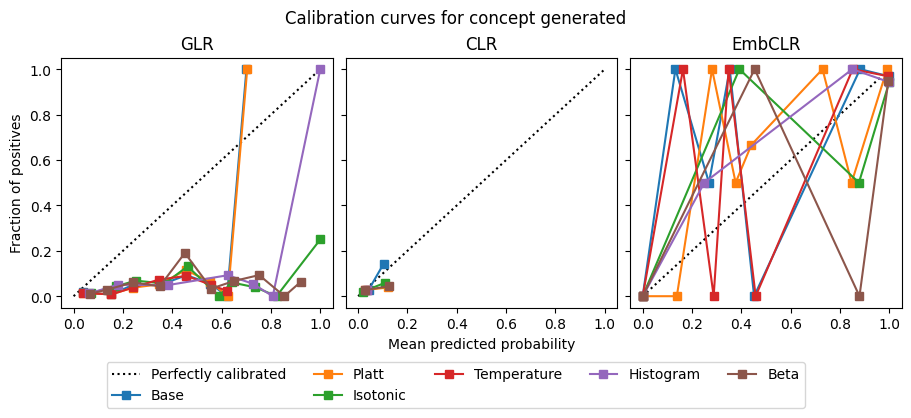

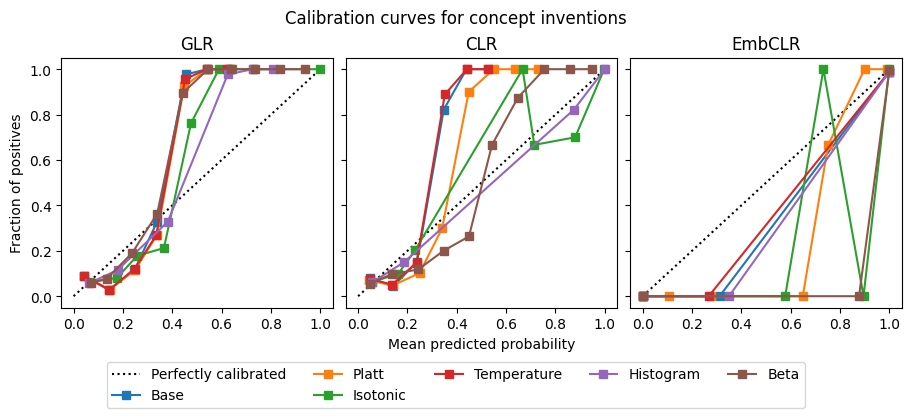

In [26]:
if len(concepts) < 10:
    for concept in concepts:
        fig = plot_calibration_curves_concept(test_metadata_df, test_cosine_similarity_df, 
                                            test_embeddings, base_models, calibrated_models,
                                            concept, results_path)
        fig.show()
else:
    for concept in concepts:
        fig = plot_calibration_curves_concept(test_metadata_df, test_cosine_similarity_df, 
                                            test_embeddings, base_models, calibrated_models,
                                            concept, results_path)
        plt.close()

### b) Calibration functions

In [27]:
output_dir = os.path.join(results_path, 'calibration_functions')
os.makedirs(output_dir, exist_ok=True)

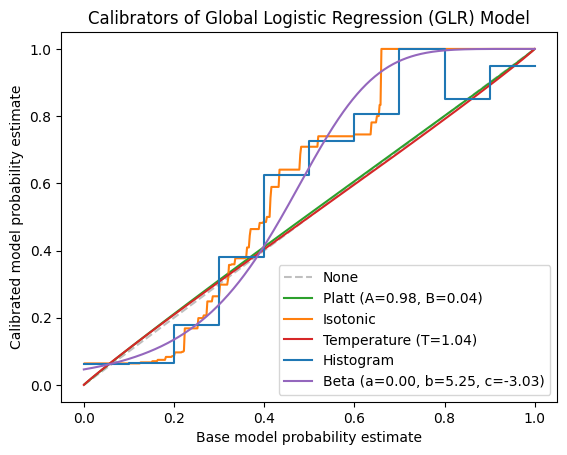

In [28]:
fname = os.path.join(output_dir, 'GLR.png')
plot_calibrators(calibrated_models['GLR'], 'Global Logistic Regression (GLR)', concept = None, path = fname)

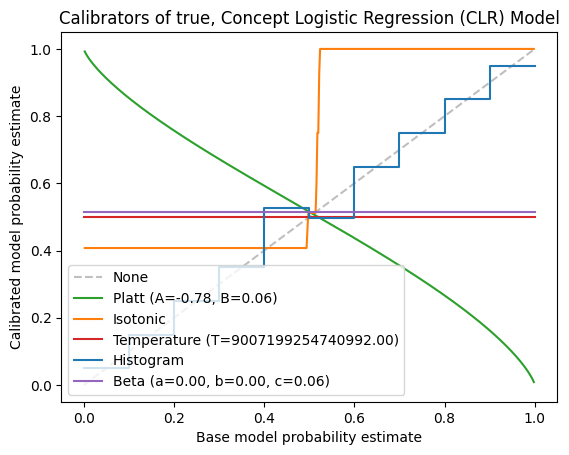

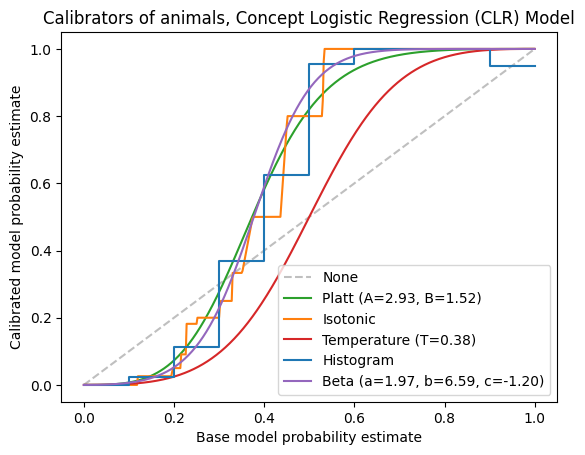

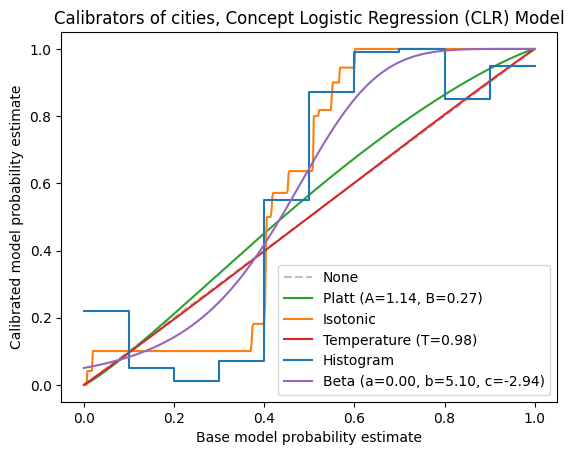

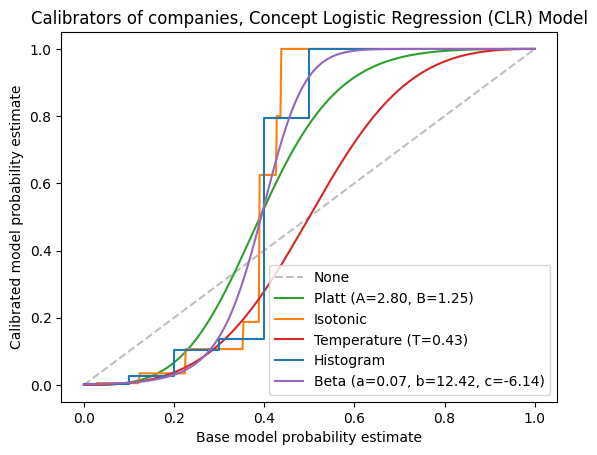

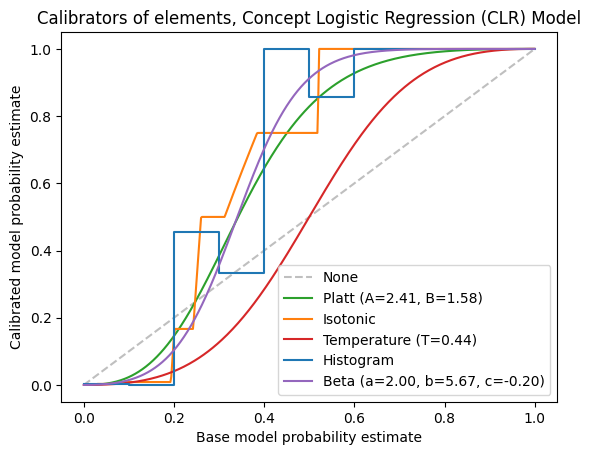

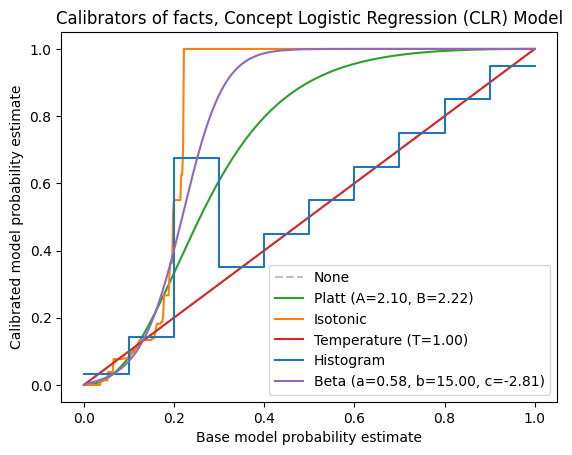

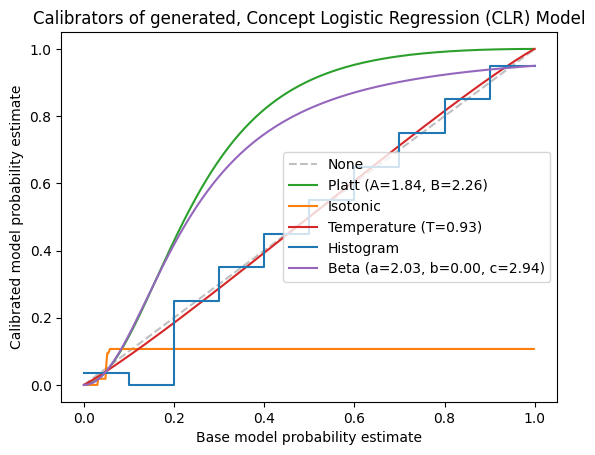

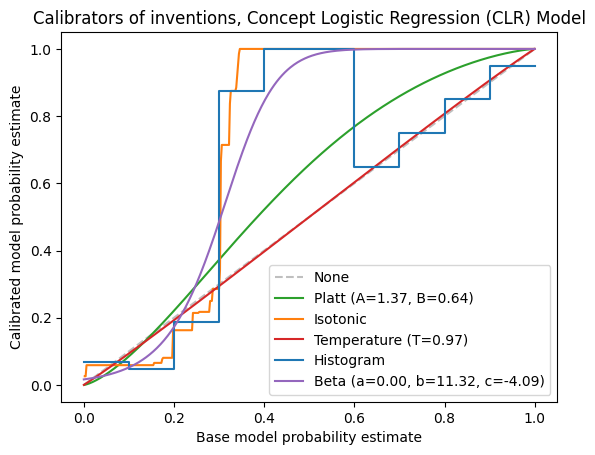

In [29]:
for concept in concepts[:min(10, len(concepts))]:
    fname = os.path.join(output_dir, 'CLR-{}.png'.format(concept))
    plot_calibrators(calibrated_models['CLR'], '{}, Concept Logistic Regression (CLR)'.format(concept), concept = concept, path = fname)

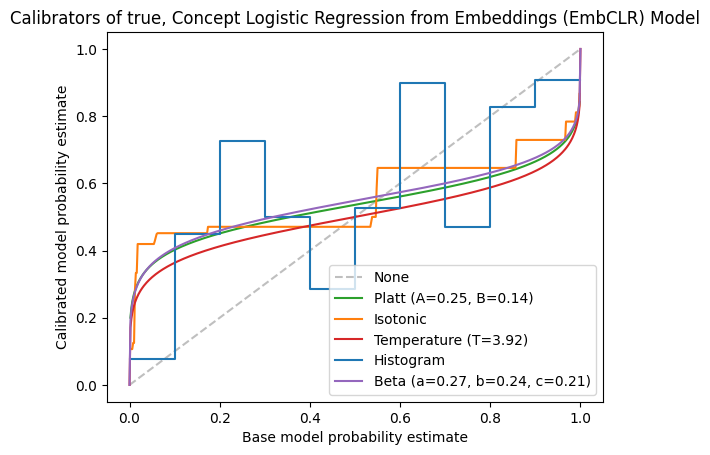

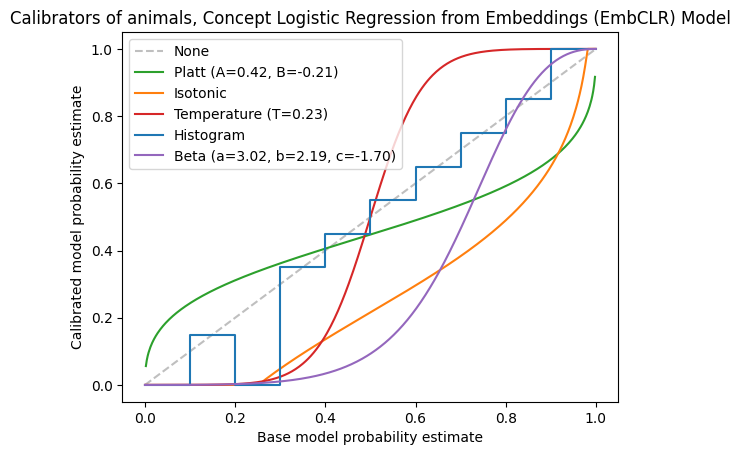

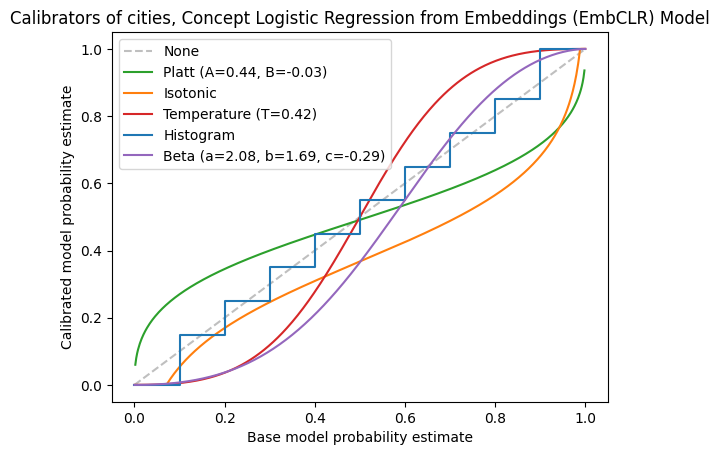

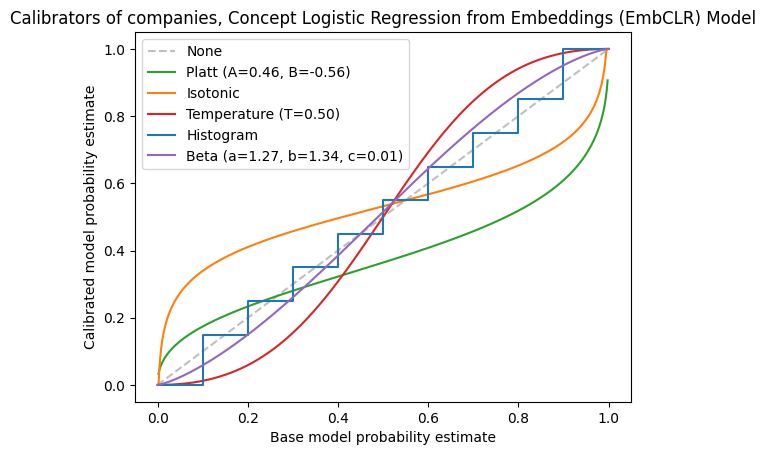

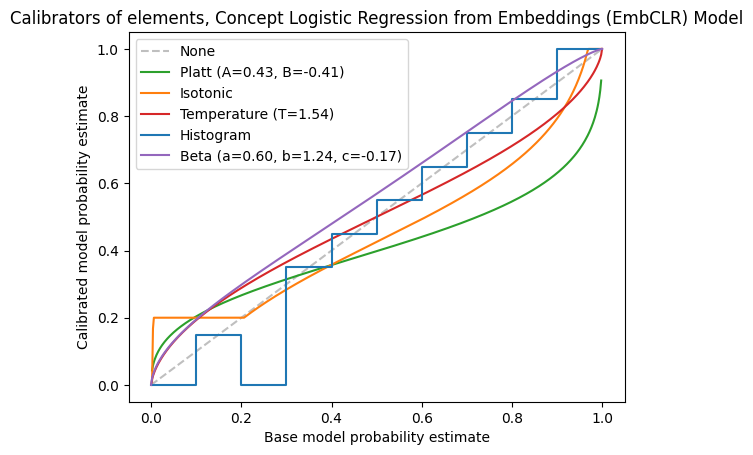

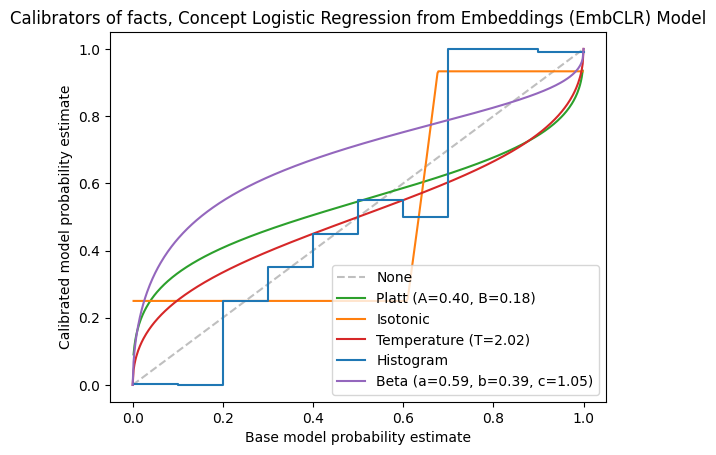

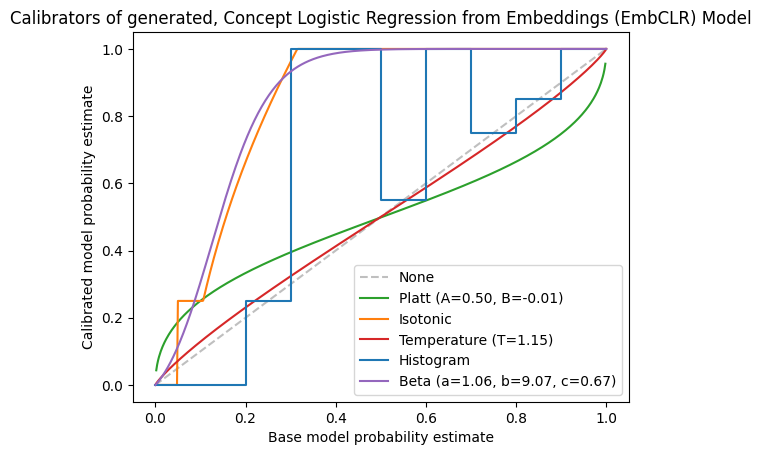

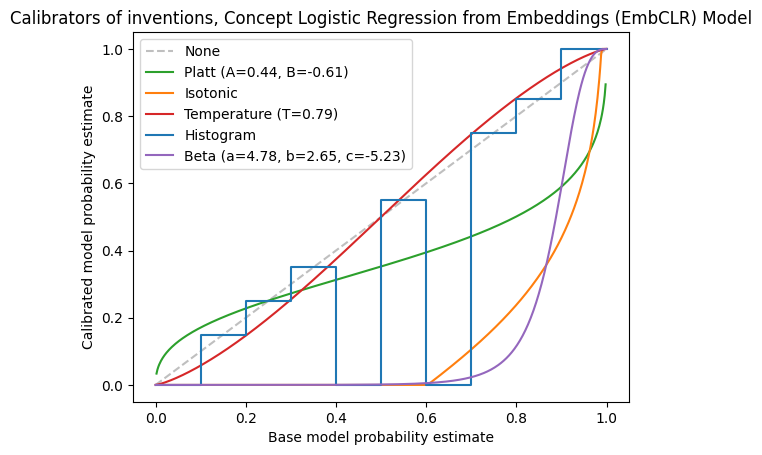

In [30]:
for concept in concepts[:min(10, len(concepts))]:
    fname = os.path.join(output_dir, 'EmbCLR-{}.png'.format(concept))
    plot_calibrators(calibrated_models['EmbCLR'], '{}, Concept Logistic Regression from Embeddings (EmbCLR)'.format(concept), 
                     concept = concept, path = fname)

## Old stuff

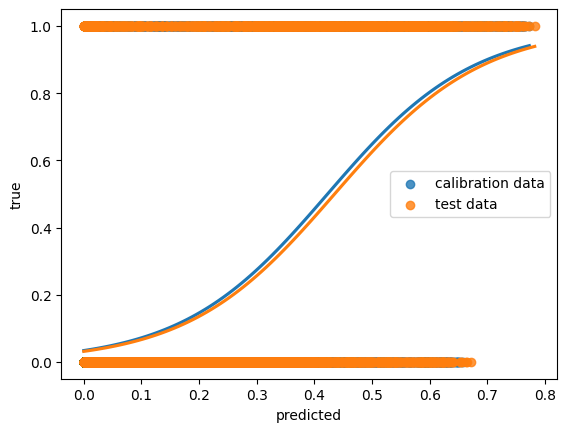

In [31]:
model = m3_models_cal['Platt']

X_cal, y_cal, _, _ = get_global_sim_X_y(cal_metadata_df, cal_cosine_similarity_df)
da_cal = pd.DataFrame.from_dict({'predicted' : m3_models.predict_proba(X_cal)[:, 1], 'true' : y_cal})

X_test, y_test, _, _ = get_global_sim_X_y(test_metadata_df, test_cosine_similarity_df)
da_test = pd.DataFrame.from_dict({'predicted' : m3_models.predict_proba(X_test)[:, 1], 'true' : y_test})

import seaborn as sns
sns.regplot(x='predicted', y='true', data = da_cal, logistic=True, ci = None, label = 'calibration data')
sns.regplot(x='predicted', y='true', data = da_test, logistic=True, ci = None, label = 'test data')

plt.legend()

# CLEVR -- uncalibrated model has total separation on the calibration set, that's not good (or is it?)

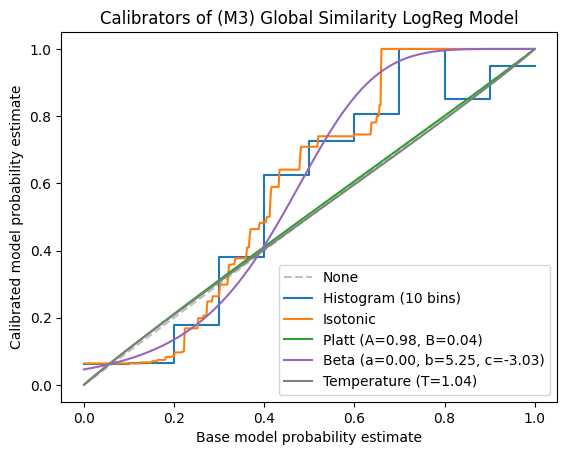

In [32]:
from scipy.special import logit, expit
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

n = 501 # discretization
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# None
plt.plot([0, 1], [0, 1], label = 'None', color = 'grey', linestyle = 'dashed', alpha = 0.5)

# Histogram binning
x_vals = m3_models_cal['Histogram'].calibrator.get_params()['_bin_bounds'][0]
y_vals = m3_models_cal['Histogram'].calibrator.get_params()['_bin_map']
y_vals = np.append(y_vals, y_vals[-1])
nbins = m3_models_cal['Histogram'].calibrator.get_params()['bins']
plt.step(x_vals, y_vals, where = 'post', label = 'Histogram ({} bins)'.format(nbins), color = colors[0])

# Isotonic regression (would be nice if I could find the true bins but this will do)
x_vals = np.linspace(0, 1, num=n, endpoint=True)[1:-1]
y_vals = m3_models_cal['Isotonic'].calibrated_classifiers_[0].calibrators[0].predict(logit(x_vals))
plt.plot(x_vals, y_vals, label = 'Isotonic', color = colors[1])

# Platt scaling
x_vals = np.linspace(0, 1, num=n, endpoint=True)[1:-1]
y_vals = m3_models_cal['Platt'].calibrated_classifiers_[0].calibrators[0].predict(logit(x_vals))
tmp = m3_models_cal['Platt'].calibrated_classifiers_[0].calibrators[0]
a, b = -tmp.a_, -tmp.b_
plt.plot(x_vals, y_vals, label = 'Platt (A={:.2f}, B={:.2f})'.format(a, b), color = colors[2])
#plt.plot(x_vals, expit(a*logit(x_vals) + b), label = 'Platt sanity check', color = 'red')

# Temperature scaling

# This matches what the code currently does on data (softmax and no logit)
#tmp = m3_models_cal['Temperature']
#T = tmp.temperature
#x_vals_vec = np.array([1 - x_vals, x_vals]).T
#y_vals = tmp.softmax(x_vals_vec / tmp.temperature)[:, 1]
#plt.plot(x_vals, y_vals, label = 'Temperature (T={:.2f})'.format(T), color = colors[3])

# Beta calibration
x_vals = np.linspace(0, 1, num=n, endpoint=True)
y_vals = m3_models_cal['Beta'].calibrator.transform(x_vals)
tmp = m3_models_cal['Beta'].calibrator.get_params()
a, b = tmp['_sites']['weights']['values']
c = tmp['_sites']['bias']['values'][0]
plt.plot(x_vals, y_vals, label = 'Beta (a={:.2f}, b={:.2f}, c={:.2f})'.format(a, b, c), color = colors[4])

## netcal

# Platt scaling v2
# x_vals = np.linspace(0, 1, num=n, endpoint=True)
# y_vals = m3_models_cal['Platt v2'].calibrator.transform(x_vals)
# a = m3_models_cal['Platt v2'].calibrator.weights[0]
# b = m3_models_cal['Platt v2'].calibrator.intercept[0]
# plt.plot(x_vals, y_vals, label = 'Platt netcal (a={:.2f}, b={:.2f})'.format(a, b), color = colors[6])
# #plt.plot(x_vals, expit(a*logit(x_vals) + b), label = 'Platt netcal sanity check', color = 'red')

# Temperature scaling v2
x_vals = np.linspace(0, 1, num=n, endpoint=True)
y_vals = m3_models_cal['Temperature'].calibrator.transform(x_vals)
T = 1 / m3_models_cal['Temperature'].calibrator.temperature[0]
plt.plot(x_vals, y_vals, label = 'Temperature (T={:.2f})'.format(T), color = colors[7])
#plt.plot(x_vals, expit(logit(x_vals) / T), label = 'Temperature netcal sanity check', color = 'red')

plt.legend()
ax.set_xlabel('Base model probability estimate')
ax.set_ylabel('Calibrated model probability estimate')
ax.set_title('Calibrators of {} Model'.format('(M3) Global Similarity LogReg'))
plt.show()

In [ ]:
# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Platt'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Platt from data', s = 6, color = 'purple')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Isotonic'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Isotonic from data', s = 6, color = 'red')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Temperature'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Temperature from data', s = 6, color = 'violet')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Beta'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Beta from data', s = 6, color = 'violet') 
# why are a bunch of these giving me double vision, maybe they're giving probabilities for both true and false labels?

# tmp = m3_models_cal['Beta'].calibrator.get_params()
# a, b = tmp['_sites']['weights']['values']
# c = tmp['_sites']['bias']['values'][0]
# y_vals = np.exp(c) * x_vals**a / (1 - x_vals)**b
# y_vals = 1 / (1 + (1/y_vals))
# plt.plot(x_vals, y_vals, label = 'Beta guess')